# Principal Component Analysis (PCA) from Scratch

In [1]:
%matplotlib inline 
%load_ext watermark
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%watermark -a 'Rachel' -v -p numpy,pandas,matplotlib,sklearn

Rachel 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.3
pandas 0.18.1
matplotlib 1.5.3
sklearn 0.18.1


## Dimensionality Reduction and PCA

The very first thing we do when given a new set of raw data is to conduct exploratory analysis to understand the basic structure of this dataset. One of the exploratory method widly used is dimensionality reduction, which is an unsupervised method that identifies simpler and more compact representations of the original raw data. Here, we'll be focusing on a specific dimensionality reduction technique called Principal Component Analysis (PCA).

Let's say in our data set, we have two features that are perfectly correlated with each other. To reduce computation complexity and to capture a compact representation of the raw features, we only have to include one feature because each feature can be easily explained by the other. In reality, when dealing with a large amount of features, it's infeasible for us to manully plot scatterplot or calculate correlation matrix to manully figure out the important features without information loss. This is where PCA comes into play. PCA converts a set of  possibly correlated variables into a set of values of linearly uncorrelated variables. 

To illustrate how PCA  works, we'll generate a simple 2-dimensional dataset to work with using the equation below.

$$x_2 = 100 + 200 \times x_1 + \epsilon$$

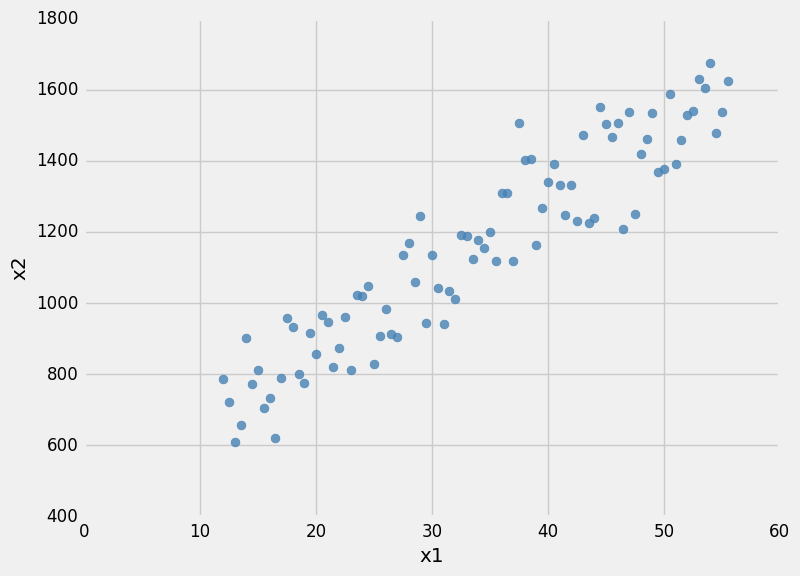

In [2]:
np.random.seed(123456)
x1 = np.arange(12, 56, 0.5)
e  = np.random.normal(0, 100, x1.shape[0])
x2 = 500 + 20 * x1 + e
X = np.c_[x1, x2]

# change default style figure and font size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

def plot2var(m):
    plt.scatter(m[:, 0], m[:, 1], s = 40, alpha = 0.8,color = 'steelblue')
    plt.xlabel('x1')
    plt.ylabel('x2')

plot2var(X)

## How PCA Works?
If it is the case that one of the features is considered redundant, we should be able to summarize the data with less characteristics (features). The way PCA tackles this problem is: 
> Instead of simply picking out the useful features and discarding the others, PCA uses a linear combination of the existing features and constructs new features that are good alternative representation of the original data. 

In our example dataset, PCA will try to pick the best single direction, or often referred to as first principal components in 2D, and project our points onto that single direction. So the next question becomes, out of the many possible lines in 2D, what line should we pick?

It turns out, there are two different answers to this question. First answer is that we are looking for some features that strongly differ across data points, thus, PCA looks for features that captures as much variation across data points as possible. The second answer is that we are looking for the features that would allow us to "reconstruct" the original features. Imagine that we come up with a feature that has no relation to the original ones; If we were to use this new feature, there is no way we can relate this to the original ones. So PCA looks for features that minimizes the reconstruction error. These two notions can be depicted in the graph below, where the black dots represents the original data point, the black line represents the projected line, the red dot on the left shows the points on the projected line and the red line on the right shows the reconstruction error.

<img src='img/pca1.png' width='80%'>

Surprisingly, it turns out that these two aims are equivalent and PCA can kill two birds with one stone. Let's look at the image below. Consider a datapoint $a_i$. The contribution of this specific data point to the total variance is $a_i^Ta_i$, or equivalently the squared Euclidean length $\lVert \mathbf{a}_i \lVert^2$. Applying the Pythagorean theorem shows that this total variance equals the sum of variance lost (the squared residual) and variance remaining. Thus, it is equivalent to either maximize remaining variance or minimize lost variance to find the principal components.

<img src='img/pca2.png' width='80%'>

Before we go another deeper, let's build some intuition using the scikit-learn library. The following section standardizes the data, fits the PCA model and prints out the important information.

In [3]:
# Before applying PCA, we should AWLAYS standardize all features
X_std = StandardScaler().fit_transform(X)

# call PCA specifying we only want the
# first two principal components (since
# we only have a 2d datset)
pca = PCA(n_components = 2)
pca.fit(X_std)

# important information
print('Components:\n ', pca.components_)
print()
print('Explained Variance Ratio:\n ', pca.explained_variance_ratio_)

Components:
  [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]

Explained Variance Ratio:
  [ 0.96791318  0.03208682]


After fitting PCA on the dataset, the fit leart some quantities from the data, most importantly the "components", which is the principal components (the new direction that our data points will be projected upon) and "explained variance ratio", which corresponds to the percentage of variance explained by each of the principal components. To get a better sense of what these numbers mean, let's visualize them over our standardized input data.

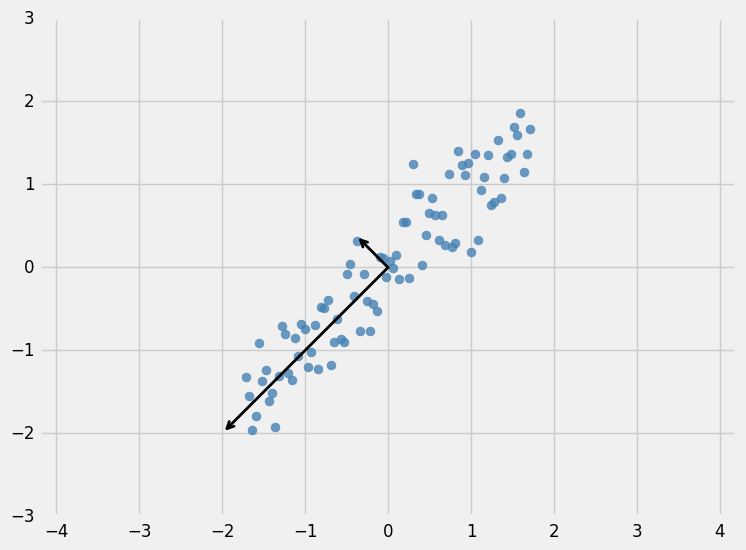

In [4]:
def draw_vector(v0, v1, ax=None):
    """draw principal components as vectors"""
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,edgecolor = 'black',
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X_std[:, 0], X_std[:, 1], s = 40, color = 'steelblue',alpha = 0.8)

for length, vector in zip(pca.explained_variance_, pca.components_):
    # the larger the explained variance, the longer the
    # annotated line will be
    v = vector * 2 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)

plt.axis('equal')
plt.show()

From the plot, we see that PCA gives us two principal components (the black line). The length of the lines indicate of how important that principal component is in describing the variation of the original data. So if we were to choose 1 principal component to summarize our 2d dataset, it will be line that has the longest length (largest explained variance ratio). There're two things worth noting:

- The number of principal components matches the total number of features
- The first and second principal components are orthogonal to each other

The reason for this is that principal components transform the data into a new set of dimensions, and these new dimensions have to be equal to the original amount of dimensions. And just like the original x-y axis we used, the new axis are alsoorthogonal to each other. If we plot these principal components beside the original data, we see the plots shown here:

Let's now reduce the dimension of our 2d dataset into 1d by transforming our data onto the most important principal component and plot it along with the original data.

[(-3, 3.1),
 (-5, 5),

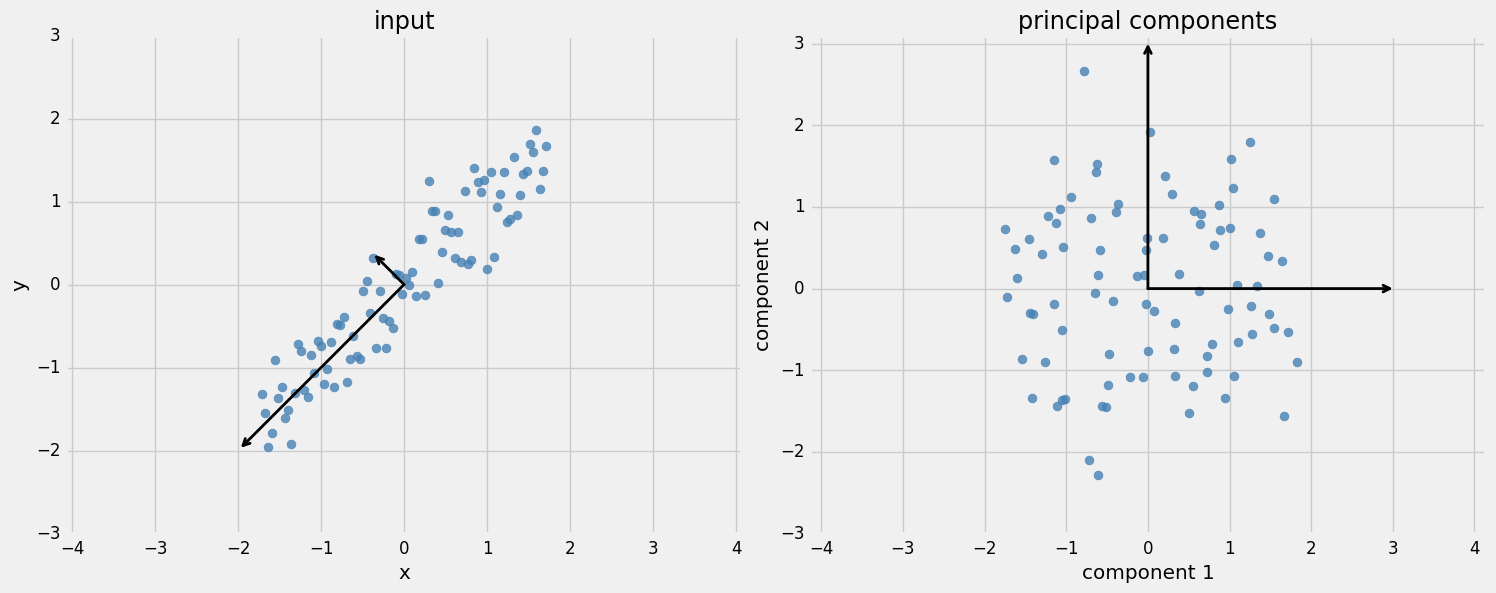

In [5]:
pca = PCA(n_components=2, whiten=True)
pca.fit(X_std)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X_std[:, 0], X_std[:, 1], s = 40, color = 'steelblue',alpha = 0.8)
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
    
# plot principal components
X_pca = pca.transform(X_std)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], s = 40, color = 'steelblue',alpha = 0.8)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
           title='principal components',
           xlim=(-5, 5), ylim=(-3, 3.1))


Let's now reduce the dimension of our 2d dataset into 1d by transforming our data onto the most important principal component and plot it along with the original data.

original shape:    (88, 2)
transformed shape: (88, 1)


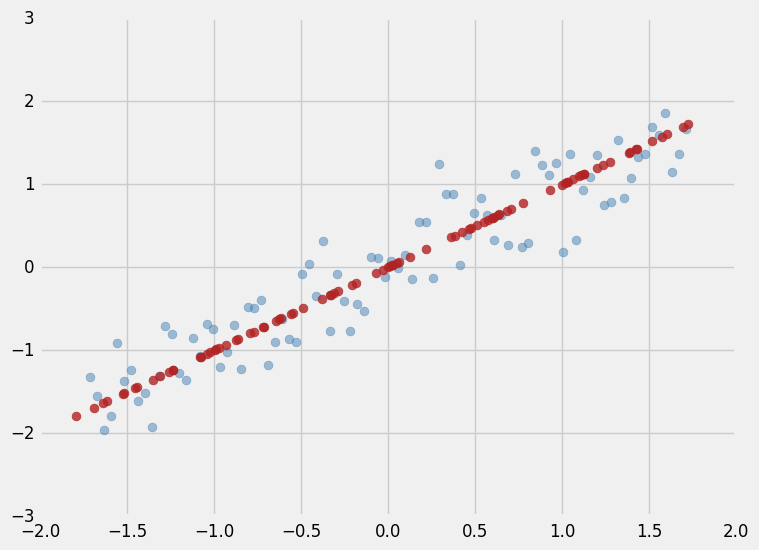

In [6]:
# dimensionality reduction, keep only
# the first principal component
pca = PCA(n_components = 1)
X_pca = pca.fit_transform(X_std)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

# inverse transform to obtain the projected data
# and compare with the original
X_new = pca.inverse_transform(X_pca)
plt.scatter(X_std[:, 0], X_std[:, 1], s = 40, alpha = 0.5,color = 'steelblue')
plt.scatter(X_new[:, 0], X_new[:, 1], s = 40, alpha = 0.8,color = 'firebrick')
plt.show()

In the plot above, the lighter blue points are the original data and the darker red points are the projected result. Looking at the projections we see that the points projected onto the first principal component all seem close to their initial representations and at the same time, it also captures most of the variations in our original data points.

In a nutshell, PCA aims to find the directions or so called the principal components of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information. In our 2d example, the linear relationship between $x_1$ and $x_2$ is mostly preserved using only 1 feature.

## PCA Algorithm
Just to summarize, the general framework for computing PCA is as follows:
- Standardize the data.
- Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix[[What are eigenvectors and eigenvalues?](http://www.visiondummy.com/2014/03/eigenvalues-eigenvectors/)]
- Sort eigenvalues in descending order and choose the *k* eigenvectors that correspond to the *k* largest eigenvalues where *k* is the number of dimensions of the new feature subspace (k≤d).
- Construct the projection matrix **W** from the selected *k* eigenvectors and project the original dataset **X** via **W** to obtain a k-dimensional feature subspace **X'**.

## Application on Iris Dataset
For the section below, we will be working with the famous "Iris" dataset to show an application of PCA.

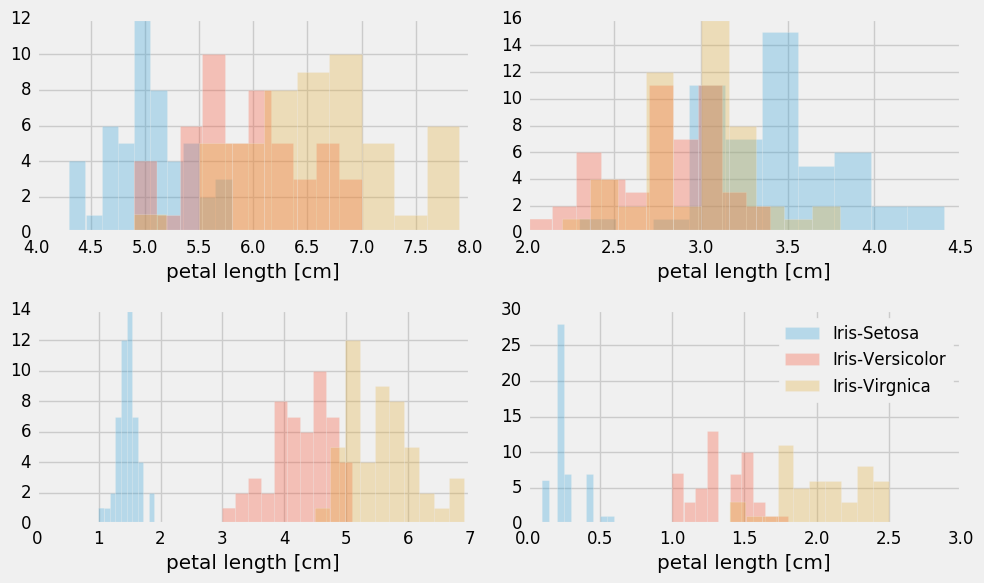

In [7]:
#get a feel of the data
iris = load_iris()
X = iris['data']
y = iris['target']

label_dict = {0: 'Iris-Setosa',
              1: 'Iris-Versicolor',
              2: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

fig = plt.figure(figsize = (10, 6))

for feature in range(len(feature_dict)):
    plt.subplot(2, 2, feature + 1)
    for index, label in label_dict.items():
        plt.hist( X[y == index, feature], label = label,
                  bins = 10, alpha = 0.3 )
        plt.xlabel(feature_dict[index])
        
plt.legend(loc = 'upper right', fancybox = True, fontsize = 12)
plt.tight_layout()
plt.show()

#### 1. Standardize the data
It's important to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it's important to standardize the data when features wwer measured on different scales (which is usually the case) so that different features will have equal contribution in terms of their scales.

In [8]:
# subtract the mean and divide the
# standard deviation of each features
mean = np.mean(X, axis = 0)
scale = np.std(X, axis = 0)
X_std = (X - mean) / scale

#### 2. Eigendecomposition - Compute Eigenvectors and Eigenvalues
The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude (variance explained along the principal components).

In [9]:
# note that since we already standardize the data,
# meaning the mean vector for each features, vec_mean 
# will be 0 (really small numbers if you were to print them out),
# hence we don't have to substract the mean to standardize them
cov_mat = X_std.T @ X_std / (X_std.shape[0] - 1)
print('Covariance matrix \n {}'.format(cov_mat) )

# equivalently, we could have used the np.cov function:
# since each row represents a variable for np.cov,
# we'll need to transpose the matrix
print( 'NumPy covariance matrix: \n {}'.format(np.cov(X_std.T)) )

Covariance matrix 
 [[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]
NumPy covariance matrix: 
 [[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


After obtaining the covariance matrix, we perform an eigendecomposition on it to obtain the eigenvalues and eigenvectors.

In [10]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' % eig_vecs)
print('\nEigenvalues \n%s' % eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.93035378  0.92740362  0.14834223  0.02074601]


#### 3. Choose Top k Eigenvectors
After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called **explained variance**, which can be calculated from the eigenvalues. The explained variance tells us how much extra information (variance) does each of the principal components contribute.

Variance Explained:  [ 0.72770452  0.23030523  0.03683832  0.00515193]
Cumulative Variance Explained:  [ 0.72770452  0.95800975  0.99484807  1.        ]


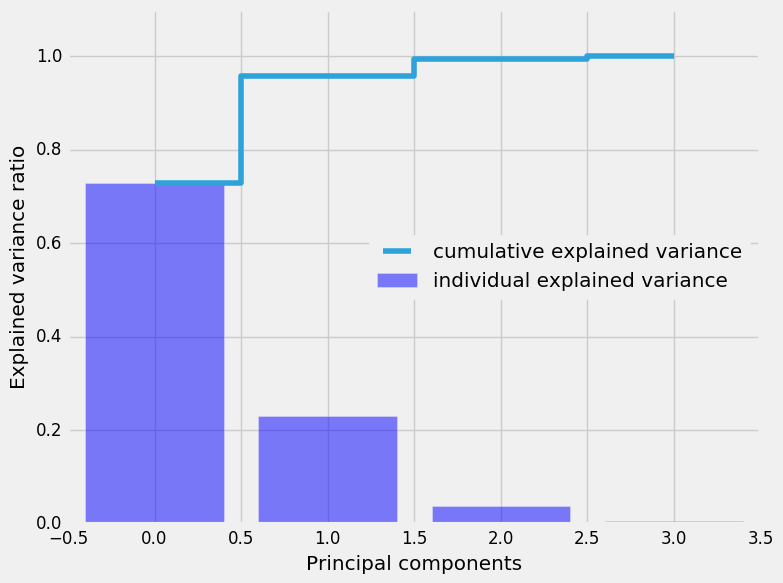

In [11]:
eig_vals_total = np.sum(eig_vals)
var_exp = eig_vals / eig_vals_total
cum_var_exp = np.cumsum(var_exp)
print('Variance Explained: ', var_exp)
print('Cumulative Variance Explained: ', cum_var_exp)

plt.bar(range(var_exp.shape[0]), var_exp, alpha = 0.5, 
        align = 'center', label = 'individual explained variance')
plt.step(range(var_exp.shape[0]), cum_var_exp, 
         where = 'mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.ylim(0, 1.1)
plt.legend(loc = 'best')
plt.tight_layout()

The plot above shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components explains 95.8% of the variance. Or in other words, it contain 95.8% of the information (95% or 99% are comon threshold that people use).

#### 4. Project Onto New Feature Space

Let's select k = 2 to capture 95% of the information.Then we will use the 4×2-dimensional eigenvectors to transform our samples onto the new subspace. In other word, We will reduce the dimension from the original 4 down to 2.

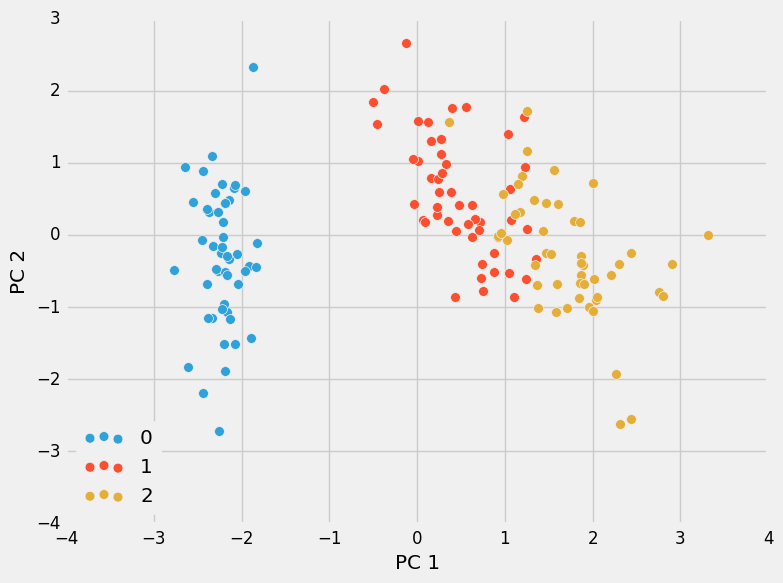

In [12]:
def plot_iris_pca(X_pca, y):
    """a scatter plot of the 2-dimensional iris data"""
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, t in enumerate(target):
        subset = X_pca[y == t]
        plt.scatter( subset[:, 0], subset[:, 1], s = 50,
                     c = colors[idx]['color'], label = t)

    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()

X_std_pca = X_std.dot(eig_vecs[:, 0:2])
plot_iris_pca(X_std_pca, y)

#### Warp up 
Finally, let's put all of this into a single class, train it and confirm the result with scikit-learn's PCA model by printing out the explained variance ratio.

In [13]:
class PCAModel:
    """
    Principal component analysis (PCA)
    
    Parameters
    ----------
    n_components : int
        top number of principal components to keep
    """    
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # standardize
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        X = (X - self.mean) / self.scale
        
        # eigendecomposition
        eig_vals, eig_vecs = np.linalg.eig(np.cov(X.T))
        self.components = eig_vecs[:, :self.n_components]
        var_exp = eig_vals / np.sum(eig_vals)
        self.explained_variance_ratio = var_exp[:self.n_components]
        return self

    def transform(self, X):
        X = X.copy()
        X = (X - self.mean) / self.scale
        X_pca = X @ self.components
        return X_pca

In [14]:
# implementation from scratch
pca_model = PCAModel(n_components = 2).fit(X)

# using library to confirm results
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
pca = PCA(n_components = 2).fit(X_std)

# print explained ratio to see if the matches
print('library: ', pca.explained_variance_ratio_)
print('from scratch: ', pca_model.explained_variance_ratio)

library:  [ 0.72770452  0.23030523]
from scratch:  [ 0.72770452  0.23030523]


## Reference
- [[Video:Principal Component Analysis (PCA) clearly explained](https://www.youtube.com/watch?v=_UVHneBUBW0)]
- [[Everything you did and didn't know about PCA ](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/)]
- [[In Depth: Principal Component Analysis](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/95664b978439df948b2cd2f5f5b4e31f28b30394/notebooks/05.09-Principal-Component-Analysis.ipynb)]